In [3]:
!pip install lightgbm


  Using cached lightgbm-3.3.5-py3-none-manylinux1_x86_64.whl (2.0 MB)

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os
# import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [3]:
user_type = pd.read_csv('data/transaction_with_labels.csv')

In [4]:
user_type[(user_type.offer_type == 'informational') & (user_type.offer_received == 1) & (user_type.offer_viewed == 1)][['offer_type', 'offer_received', 'offer_viewed', 'received_viewed', 'amount_spent']]

,offer_type,offer_received,offer_viewed,received_viewed,amount_spent
5,informational,1,1,48.0,19.89
6,informational,1,1,48.0,17.78
7,informational,1,1,48.0,19.67
8,informational,1,1,48.0,29.72
9,informational,1,1,48.0,23.93
...,...,...,...,...,...
148650,informational,1,1,60.0,5.93
148652,informational,1,1,60.0,1.74
148654,informational,1,1,60.0,2.16
148656,informational,1,1,60.0,6.61


In [5]:
user_type.columns

Index(['age', 'gender', 'income', 'became_member_on', 'membership_duration',
       'person', 'event', 'time', 'amount_spent', 'offer_received',
       'time_received', 'offer_id', 'offer_viewed', 'time_viewed',
       'offer_completed', 'time_completed', 'reward_received', 'offer',
       'offer_type', 'difficulty', 'duration', 'reward', 'channels', 'web',
       'email', 'social', 'mobile', 'duration_hr', 'received_viewed',
       'viewed_completed', 'received_completed_diff', 'duration_diff',
       'valid_complete', 'completed', 'label'],
      dtype='object')

In [6]:
user_type.drop(['became_member_on', 'event', 'time', 'offer_received',
       'time_received', 'offer_id', 'offer_viewed', 'time_viewed',
       'offer_completed', 'time_completed', 'reward_received', 'offer',
       'offer_type', 'channels', 'duration_hr', 'received_viewed',
       'viewed_completed', 'received_completed_diff', 'duration_diff', 'person', 'valid_complete', 'amount_spent', 'completed'], axis = 1, inplace = True)

In [7]:
user_type

,age,gender,income,membership_duration,difficulty,duration,reward,web,email,social,mobile,label
0,55,F,112000.0,376,0,4,0,1,1,0,1,buy without offer
1,55,F,112000.0,376,0,4,0,1,1,0,1,buy without offer
2,55,F,112000.0,376,5,7,5,1,1,0,1,buy without offer
3,55,F,112000.0,376,0,4,0,1,1,0,1,buy without offer
4,75,F,100000.0,443,5,7,5,1,1,0,1,bogo buyers
...,...,...,...,...,...,...,...,...,...,...,...,...
148668,62,F,82000.0,369,0,4,0,1,1,0,1,buy without offer
148669,62,F,82000.0,369,0,4,0,1,1,0,1,buy without offer
148670,62,F,82000.0,369,0,4,0,1,1,0,1,buy without offer
148671,62,F,82000.0,369,0,4,0,1,1,0,1,buy without offer


In [8]:
def _transform_column_into_dummies(dataframe, names_of_column):
    
    to_concat = [dataframe]
    
    for name in names_of_column:
        dummies = pd.get_dummies(dataframe[name], prefix=f"{name} = ")
        to_concat.append(dummies)
    
    dataframe = pd.concat(to_concat, axis=1)
    
    dataframe = dataframe.drop(names_of_column, axis=1)
    
    return dataframe

user_type = _transform_column_into_dummies(user_type, ['gender'])

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
le_label = LabelEncoder()
user_type['label'] = le_label.fit_transform(user_type['label'])

In [11]:
user_type['label']

0         1
1         1
2         1
3         1
4         0
         ..
148668    1
148669    1
148670    1
148671    1
148672    1
Name: label, Length: 148673, dtype: int64

In [12]:
user_types = le_label.inverse_transform(user_type['label'])

In [13]:
labels = pd.DataFrame({'label': user_type['label'], 'decoded': user_types})

In [14]:
labels['decoded'].unique()

array(['buy without offer', 'bogo buyers', 'informational buyers',
       'discount buyers'], dtype=object)

In [15]:
labels['label'].unique()

array([1, 0, 3, 2])

In [16]:
X = user_type.drop('label', axis = 1)
y = user_type['label']

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle = True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, shuffle = True) # 0.25 x 0.8 = 0.2

In [18]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)

In [19]:
tree_clf.classes_

array([0, 1, 2, 3])

In [20]:
tree_pred = tree_clf.predict(X_val)

In [23]:
tree_proba = tree_clf.predict_proba(X_val)

In [24]:
tree_f1 = f1_score(tree_pred, y_val, average = 'weighted')

In [25]:
print(tree_f1)

0.7717056202247666


Feature ranking:
1. feature 5 age (0.368314)
2. feature 2 income (0.228225)
3. feature 1 membership_duration (0.140089)
4. feature 0 difficulty (0.134784)
5. feature 9 duration (0.043425)
6. feature 4 reward (0.038585)
7. feature 8 web (0.017781)
8. feature 10 email (0.012961)
9. feature 11 social (0.012257)
10. feature 12 mobile (0.002516)
11. feature 3 gender = _F (0.000573)
12. feature 6 gender = _M (0.000490)
13. feature 7 gender = _O (0.000000)


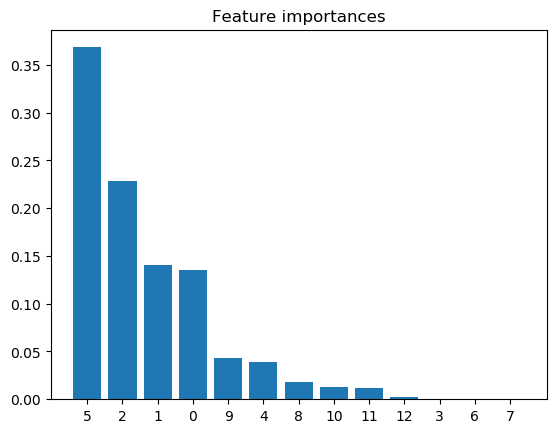

In [26]:
# get feature importances
tree_importances = tree_clf.feature_importances_

# sort feature importances in descending order
indices = np.argsort(tree_importances)[::-1]

# print out the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[f], tree_importances[indices[f]]))

# plot the feature importances
plt.title("Feature importances")
plt.bar(range(X.shape[1]), tree_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()

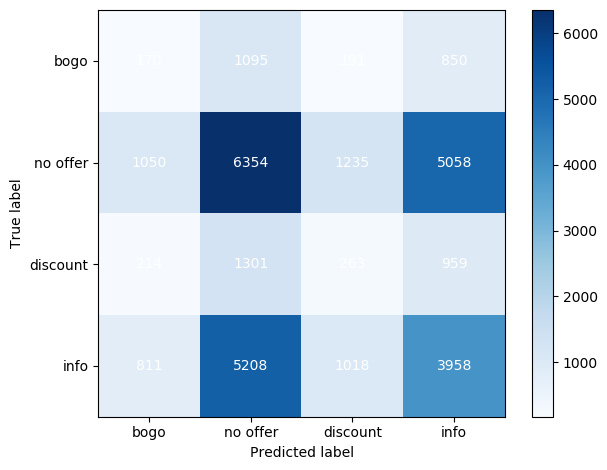

In [27]:
# Compute the confusion matrix
tree_cm = confusion_matrix(y_test, tree_pred)

# Visualize the confusion matrix as a heatmap
fig, ax = plt.subplots()
im = ax.imshow(tree_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(tree_cm.shape[1]),
       yticks=np.arange(tree_cm.shape[0]),
       xticklabels=['bogo', 'no offer', 'discount', 'info'],
       yticklabels=['bogo', 'no offer', 'discount', 'info'],
       xlabel='Predicted label',
       ylabel='True label')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Loop over data to add annotations
for i in range(tree_cm.shape[0]):
    for j in range(tree_cm.shape[1]):
        ax.text(j, i, tree_cm[i, j], ha="center", va="center", color="white")

fig.tight_layout()
plt.show()

In [95]:
forest_clf = RandomForestClassifier(max_depth=2, random_state=0)
forest_clf = forest_clf.fit(X_train, y_train)

In [96]:
forest_pred = forest_clf.predict(X_val)

In [97]:
forest_f1 = f1_score(forest_pred, y_val, average = "weighted")

In [98]:
print(forest_f1)

0.6536167519674068


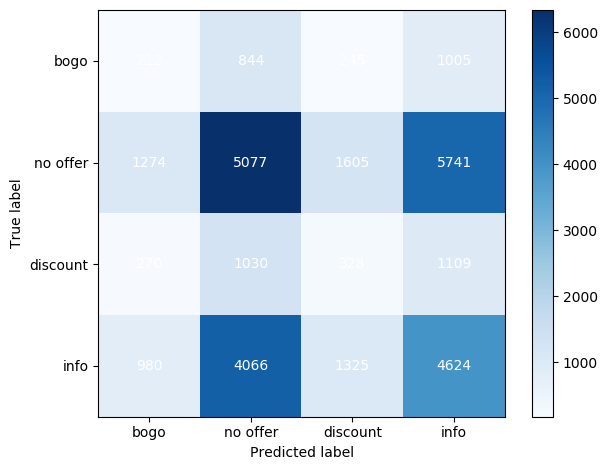

In [99]:
# Compute the confusion matrix
forest_cm = confusion_matrix(y_test, forest_pred)

# Visualize the confusion matrix as a heatmap
fig, ax = plt.subplots()
im = ax.imshow(tree_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(forest_cm.shape[1]),
       yticks=np.arange(forest_cm.shape[0]),
       xticklabels=['bogo', 'no offer', 'discount', 'info'],
       yticklabels=['bogo', 'no offer', 'discount', 'info'],
       xlabel='Predicted label',
       ylabel='True label')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Loop over data to add annotations
for i in range(forest_cm.shape[0]):
    for j in range(forest_cm.shape[1]):
        ax.text(j, i, forest_cm[i, j], ha="center", va="center", color="white")

fig.tight_layout()
plt.show()

Feature ranking:
1. feature 5 age (0.290664)
2. feature 4 income (0.268262)
3. feature 3 membership_duration (0.214339)
4. feature 8 difficulty (0.115609)
5. feature 6 duration (0.074392)
6. feature 9 reward (0.020484)
7. feature 1 web (0.012284)
8. feature 0 email (0.002538)
9. feature 2 social (0.001120)
10. feature 10 mobile (0.000137)
11. feature 11 gender = _F (0.000098)
12. feature 12 gender = _M (0.000072)
13. feature 7 gender = _O (0.000000)


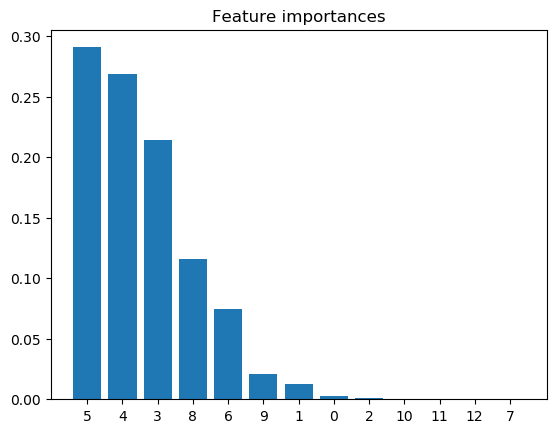

In [100]:
# get feature importances
forest_importances = forest_clf.feature_importances_

# sort feature importances in descending order
indices = np.argsort(forest_importances)[::-1]

# print out the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[f], forest_importances[indices[f]]))

# plot the feature importances
plt.title("Feature importances")
plt.bar(range(X.shape[1]), forest_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()


In [101]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf = lgb_clf.fit(X_train, y_train)

In [102]:
lgb_pred = lgb_clf.predict(X_val)

In [103]:
lgb_f1 = f1_score(lgb_pred, y_val, average = "weighted")

In [104]:
print(lgb_f1)

0.7018644582952969


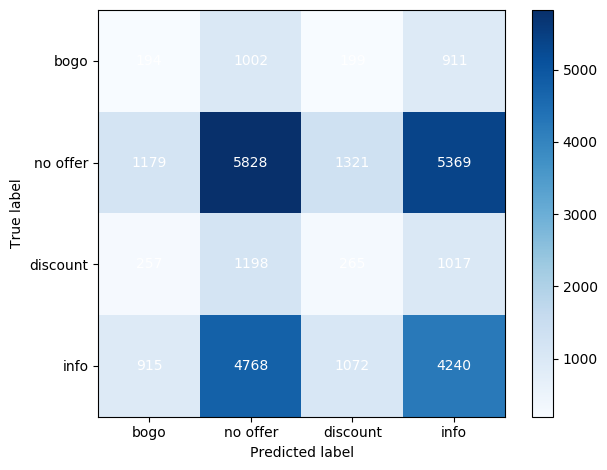

In [105]:
# Compute the confusion matrix
lgb_cm = confusion_matrix(y_test, lgb_pred)

# Visualize the confusion matrix as a heatmap
fig, ax = plt.subplots()
im = ax.imshow(lgb_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(lgb_cm.shape[1]),
       yticks=np.arange(lgb_cm.shape[0]),
       xticklabels=['bogo', 'no offer', 'discount', 'info'],
       yticklabels=['bogo', 'no offer', 'discount', 'info'],
       xlabel='Predicted label',
       ylabel='True label')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Loop over data to add annotations
for i in range(lgb_cm.shape[0]):
    for j in range(lgb_cm.shape[1]):
        ax.text(j, i, lgb_cm[i, j], ha="center", va="center", color="white")

fig.tight_layout()
plt.show()

Feature ranking:
1. feature 2 age (3961.000000)
2. feature 1 income (3166.000000)
3. feature 0 membership_duration (3103.000000)
4. feature 3 difficulty (346.000000)
5. feature 4 duration (314.000000)
6. feature 10 reward (273.000000)
7. feature 5 web (255.000000)
8. feature 8 email (239.000000)
9. feature 11 social (131.000000)
10. feature 12 mobile (97.000000)
11. feature 6 gender = _F (90.000000)
12. feature 9 gender = _M (25.000000)
13. feature 7 gender = _O (0.000000)


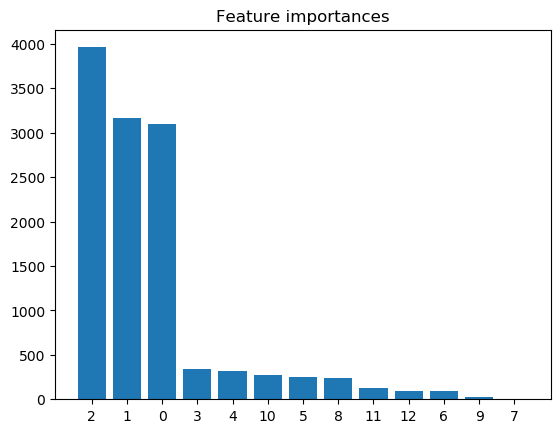

In [106]:
# get feature importances
lgb_importances = lgb_clf.feature_importances_

# sort feature importances in descending order
indices = np.argsort(lgb_importances)[::-1]

# print out the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[f], lgb_importances[indices[f]]))

# plot the feature importances
plt.title("Feature importances")
plt.bar(range(X.shape[1]), lgb_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

In [52]:
models = []
models.append(('DT', tree.DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('LGBM', lgb.LGBMClassifier()))

In [53]:
X_train

,age,income,membership_duration,difficulty,duration,reward,web,email,social,mobile,gender = _F,gender = _M,gender = _O
114666,72,50000.0,230,0,3,0,0,1,1,1,0,1,0
1769,83,54000.0,353,0,3,0,0,1,1,1,0,1,0
108084,69,67000.0,565,0,3,0,0,1,1,1,0,1,0
19214,53,34000.0,978,0,3,0,0,1,1,1,0,1,0
98045,23,33000.0,991,10,7,2,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131665,80,61000.0,215,0,4,0,1,1,0,1,0,1,0
143976,40,37000.0,361,0,3,0,0,1,1,1,0,1,0
79796,68,39000.0,778,0,3,0,0,1,1,1,0,1,0
90823,59,48000.0,1085,0,3,0,0,1,1,1,0,0,1


In [54]:
y_train

114666    3
1769      1
108084    3
19214     3
98045     2
         ..
131665    1
143976    3
79796     1
90823     3
77955     3
Name: label, Length: 89203, dtype: int64

In [55]:
f1_results = []
f1_names = []
scoring = 'f1_weighted'
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for name, model in models:
    trans = StandardScaler()
    pipeline = Pipeline(steps=[('t', trans), ('m', model)])
    cv_results = cross_val_score(pipeline, 
                                    X_train, 
                                    y_train, 
                                    scoring = scoring, 
                                    cv = cv)
    f1_results.append(abs(cv_results))
    f1_names.append(name)
    msg = "%s: %f (%f)" % (name, abs(cv_results.mean()), cv_results.std())
    print(abs(cv_results), msg)

[0.78247508 0.77750571 0.76938126 0.77677906 0.77482885 0.76517126
 0.7748894  0.77078486 0.77323705 0.77347329] DT: 0.773853 (0.004512)
[0.78634236 0.78657309 0.77587944 0.78570109 0.77733072 0.7759713
 0.78018463 0.7751598  0.77892144 0.78247084] RF: 0.780453 (0.004300)
[0.69859386 0.70208058 0.69884833 0.7010827  0.6947414  0.68615276
 0.69665351 0.68607724 0.69893126 0.69695048] LGBM: 0.696011 (0.005335)


<Figure size 640x480 with 0 Axes>

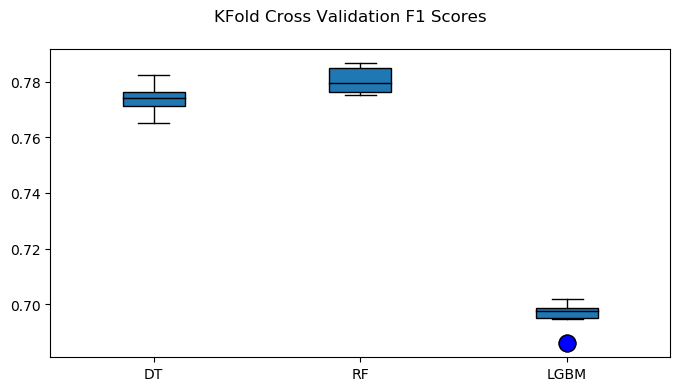

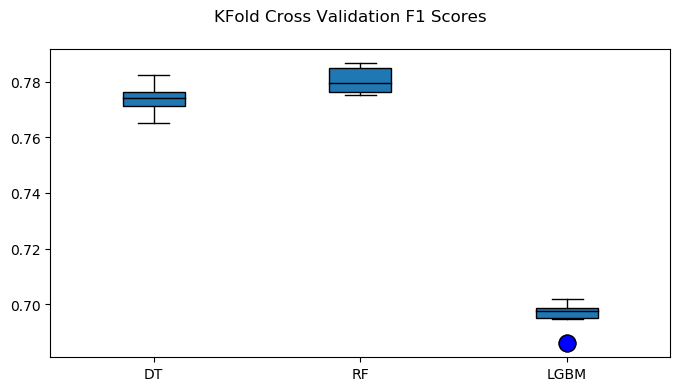

In [70]:
fig = plt.figure(figsize=(8,4))
fig.suptitle('KFold Cross Validation F1 Scores', color = 'black')
ax = fig.add_subplot(111)

plt.boxplot(f1_results, vert = True, patch_artist = True, manage_ticks = True,
            medianprops = {"color":'black'}, 
            whiskerprops = {"color": 'black'}, 
            capprops = {"color": 'black'}, 
            boxprops = {"color": 'black'}, 
            flierprops = {"marker":'o', 
                          "markerfacecolor":'b', 
                          "markersize": 12})

ax.set_xticklabels(f1_names)

plt.show()

# plt.savefig(os.path.join('photos/kfold_f1_weighted.png'), dpi=300, format='png', bbox_inches='tight') 


In [24]:
#Show default parameters of Random Forest Classifier
rfc = RandomForestClassifier()
params = rfc.get_params()
params_df = pd.DataFrame(params, index=[0])
params_df.T

,0
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


In [25]:
params = {'bootstrap': [True], 
          'max_depth': [21, 22, 23],
          'max_features': ['auto', 'sqrt'], 
          'min_samples_leaf': [5, 6],
          'min_samples_split': [8, 9],
          'n_estimators': [2400, 2600, 2800]}

In [26]:
from sklearn.model_selection import RandomizedSearchCV
clf = RandomizedSearchCV(estimator=rfc, 
                         param_distributions=params,
                         n_iter = 10,
                         scoring='f1_weighted',
                         cv = 10,
                         verbose=1)
clf.fit(X_val, y_val)
print("Best parameters:", clf.best_params_)
print("Best F1 Score: ", (clf.best_score_))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 118.5min finished


Best parameters: {'n_estimators': 2600, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 22, 'bootstrap': True}
Best F1 Score:  0.7210746416223268


In [ ]:
# Best parameters: {'n_estimators': 1200, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': True}
# Best F1 Score:  0.6567192957084993
# Done 100 out of 100 | elapsed: 39.3min finished
# Best parameters: {'n_estimators': 1400, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
# Best F1 Score:  0.6639897886058146
#  Done 100 out of 100 | elapsed: 60.2min finished
# Best parameters: {'n_estimators': 1800, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 14, 'bootstrap': True}
# Best F1 Score:  0.6955699849546477
# 101.5min finished
# Best parameters: {'n_estimators': 2000, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 18, 'bootstrap': True}
# Best F1 Score:  0.715171630237237
#  elapsed: 106.8min finished
# Best parameters: {'n_estimators': 2000, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
# Best F1 Score:  0.7182621544156161
# Best parameters: {'n_estimators': 2400, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 21, 'bootstrap': True}
# Best F1 Score:  0.7203899362990696
# elapsed: 141.4min finished
# Best parameters: {'n_estimators': 2400, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 23, 'bootstrap': True}
# Best F1 Score:  0.7213919813019442
# Best parameters: {'n_estimators': 2600, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 22, 'bootstrap': True}
# Best F1 Score:  0.7210746416223268

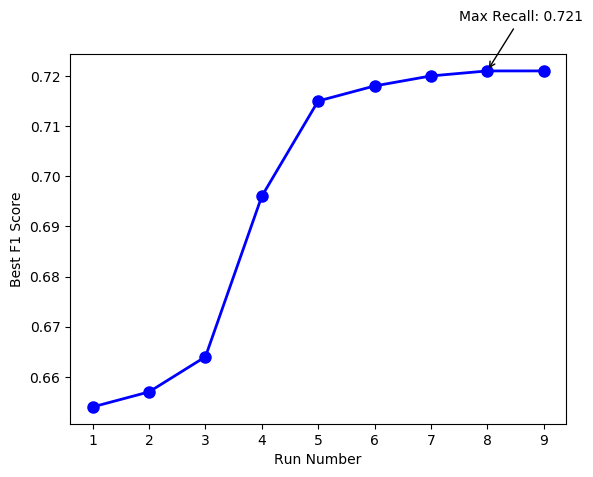

In [2]:
import matplotlib.pyplot as plt

best_recall = [0.654, 0.657, 0.664, 0.696, 0.715, 0.718, 0.720, 0.721, 0.721]
runs = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the line graph
ax.plot(runs, best_recall, '-o', color='blue', linewidth=2, markersize=8)

# Add text annotation for the highest value
max_recall = max(best_recall)
max_run = runs[best_recall.index(max_recall)]
ax.annotate(f'Max Recall: {max_recall:.3f}', xy=(max_run, max_recall), xytext=(max_run-0.5, max_recall+0.01),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

# Set axis labels and title
ax.set_xlabel('Run Number')
ax.set_ylabel('Best F1 Score')

# Show the plot
plt.show()

In [21]:
best_rf = RandomForestClassifier(n_estimators = 2400, 
                       min_samples_split = 8, 
                       min_samples_leaf = 5, 
                       max_features = 'sqrt', 
                       max_depth = 23, 
                       bootstrap = True)

best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=23, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=2400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
best_pred = best_rf.predict(X_test)

In [24]:
best_pred

array([3, 1, 3, ..., 1, 3, 3])

In [37]:
best_pred_df.shape

(29735, 2)

In [38]:
X_test.shape

(29735, 13)

In [40]:
best_pred_df = pd.DataFrame({'actual': y_test, 'predicted': best_pred})


In [43]:
best_pred_df = pd.merge(left = best_pred_df, right = X_test, how = "inner" , left_on = best_pred_df.index, right_on=X_test.index)

In [44]:
best_pred_df.shape

(29735, 16)

In [47]:
# best_pred_df.to_csv('usertype_results.csv', index = False)

In [4]:
best_pred_df = pd.read_csv('usertype_results.csv')

In [5]:
best_pred_df

,key_0,actual,predicted,age,income,membership_duration,difficulty,duration,reward,web,email,social,mobile,gender = _F,gender = _M,gender = _O
0,39279,3,3,76,53000.0,1403,0,4,0,1,1,0,1,1,0,0
1,23756,1,1,39,74000.0,935,0,3,0,0,1,1,1,0,1,0
2,142514,3,3,49,31000.0,126,0,3,0,0,1,1,1,1,0,0
3,10020,1,3,51,66000.0,245,0,4,0,1,1,0,1,0,1,0
4,73339,1,1,21,39000.0,1072,0,4,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29730,65042,3,3,71,75000.0,487,0,3,0,0,1,1,1,0,1,0
29731,26572,1,3,66,51000.0,434,0,3,0,0,1,1,1,0,1,0
29732,8675,1,1,88,71000.0,488,20,10,5,1,1,0,0,1,0,0
29733,48818,3,3,36,70000.0,900,0,3,0,0,1,1,1,1,0,0


In [54]:
# Create age groups by rounding down to the nearest 20
best_pred_df['age_group'] = (best_pred_df['age'] // 20) * 20

# Create a list of unique age groups in the DataFrame, sorted in ascending order
age_groups = sorted(best_pred_df['age_group'].unique())

# Create a dictionary to map predicted values to labels for the pie charts
labels_dict = {0: 'BOGO Buyers', 1: 'Buy Without Offers', 2: 'Discount Buyers', 3: 'Informational Buyers'}

# Create a pie chart for each age group and predicted value
for age_group in age_groups:
    # Get the subset of the DataFrame for the current age group
    subset = best_pred_df[best_pred_df['age_group'] == age_group]
    
    # Count the number of occurrences of each predicted value in the subset
    counts = subset['predicted'].value_counts()
    
    # Create a pie chart
    plt.figure()
    plt.pie(counts, labels=[labels_dict.get(x, '') for x in counts.index], autopct='%1.1f%%')
    plt.title('Age Group: {} - {}'.format(age_group, age_group+19))
    plt.axis('equal')
    # plt.savefig(os.path.join(f'photos/result_user_types_{age_group}.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

plt.show()

In [63]:
# Define the minimum and maximum income values
min_income = min(best_pred_df['income'])
max_income = max(best_pred_df['income'])

# Define the number of income groups
num_income_groups = 6

# Calculate the income range for each group
income_range = (max_income - min_income) / num_income_groups

# Create income groups by rounding down to the nearest income range
best_pred_df['income_group'] = (best_pred_df['income'] // income_range) * income_range

# Create a list of unique income groups in the DataFrame, sorted in ascending order
income_groups = sorted(best_pred_df['income_group'].unique())

# Create a dictionary to map predicted values to labels for the pie charts
labels_dict = {0: 'BOGO Buyers', 1: 'Buy Without Offers', 2: 'Discount Buyers', 3: 'Informational Buyers'}

# Create a pie chart for each income group and predicted value
for income_group in income_groups:
    # Get the subset of the DataFrame for the current income group
    subset = best_pred_df[best_pred_df['income_group'] == income_group]
    
    # Count the number of occurrences of each predicted value in the subset
    counts = subset['predicted'].value_counts()
    
    # Create a pie chart
    plt.figure()
    plt.pie(counts, labels=[labels_dict.get(x, '') for x in counts.index], autopct='%1.1f%%')
    plt.title('Income Group: {} - {}'.format(income_group, income_group+income_range))
    plt.axis('equal')
    # plt.savefig(os.path.join(f'photos/result_user_types_{income_group}.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


# plt.show()


In [55]:
min(best_pred_df['income'])

30000.0

In [56]:
max(best_pred_df['income'])

120000.0

In [64]:
min(best_pred_df['membership_duration'])

0

In [65]:
max(best_pred_df['membership_duration'])

1823

In [69]:
# Define the minimum and maximum membership duration values
min_duration = min(best_pred_df['membership_duration'])
max_duration = max(best_pred_df['membership_duration'])

# Define the number of membership duration groups
num_duration_groups = 6

# Calculate the membership duration range for each group
duration_range = (max_duration - min_duration) / num_duration_groups

# Create membership duration groups by rounding down to the nearest income range
best_pred_df['duration_group'] = (best_pred_df['membership_duration'] // duration_range) * duration_range

# Create a list of unique duration groups in the DataFrame, sorted in ascending order
duration_groups = sorted(best_pred_df['duration_group'].unique())

# Create a dictionary to map predicted values to labels for the pie charts
labels_dict = {0: 'BOGO Buyers', 1: 'Buy Without Offers', 2: 'Discount Buyers', 3: 'Informational Buyers'}

# Create a pie chart for each duration group and predicted value
for duration_group in duration_groups:
    # Get the subset of the DataFrame for the current income group
    subset = best_pred_df[best_pred_df['duration_group'] == duration_group]
    
    # Count the number of occurrences of each predicted value in the subset
    counts = subset['predicted'].value_counts()
    
    # Create a pie chart
    plt.figure()
    plt.pie(counts, labels=[labels_dict.get(x, '') for x in counts.index], autopct='%1.1f%%')
    plt.title('Duration Group: {} - {}'.format(duration_group, duration_group+duration_range))
    plt.axis('equal')
    # plt.savefig(os.path.join(f'photos/result_user_types_duration_{duration_group}.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


# plt.show()

In [83]:
# Create a dictionary to map predicted values to labels for the pie charts
labels_dict = {0: 'BOGO Buyers', 1: 'Buy Without Offers', 2: 'Discount Buyers', 3: 'Informational Buyers'}

# Round off the membership duration column to the nearest integer
best_pred_df['membership_duration'] = best_pred_df['membership_duration'].round()

# Define the minimum and maximum membership duration values
min_duration = min(best_pred_df['membership_duration'])
max_duration = max(best_pred_df['membership_duration'])

# Define the number of membership duration groups
num_duration_groups = 6

# Calculate the membership duration range for each group
duration_range = (max_duration - min_duration) / num_duration_groups

# Create membership duration groups by rounding down to the nearest income range
best_pred_df['duration_group'] = (best_pred_df['membership_duration'] // duration_range) * duration_range

# Create a list of unique duration groups in the DataFrame, sorted in ascending order
duration_groups = sorted(best_pred_df['duration_group'].unique())

# Create a pie chart for each duration group and predicted value
for duration_group in duration_groups:
    # Get the subset of the DataFrame for the current duration group
    subset = best_pred_df[best_pred_df['duration_group'] == duration_group]
    
    # Count the number of occurrences of each predicted value in the subset
    counts = subset['predicted'].value_counts()
    
    # Round off the title values to the nearest integer
    duration_group_title = round(duration_group)
    duration_group_range_title = round(duration_group + duration_range)
    
    # Create a pie chart
    plt.figure()
    plt.pie(counts, labels=[labels_dict.get(x, '') for x in counts.index], autopct='%1.1f%%')
    plt.title('Duration Group: {} - {}'.format(duration_group_title, duration_group_range_title))
    plt.axis('equal')
    # plt.savefig(os.path.join(f'photos/result_user_types_duration_{duration_group}.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


plt.show()



In [13]:
# Create a dictionary to map predicted values to labels for the pie charts
labels_dict = {0: 'BOGO Buyers', 1: 'Buy Without Offers', 2: 'Discount Buyers', 3: 'Informational Buyers'}

# Group the data by predicted value and sum the male, female, and other columns
counts = best_pred_df.groupby('predicted')[['gender = _M', 'gender = _F', 'gender = _O']].sum()

# Create a stacked bar chart
counts.plot(kind='bar')

# Set the title and axis labels
plt.title('Number of Users by Predicted User Type and Gender')
plt.xlabel('Predicted User Type')
plt.ylabel('Count')

# Set the legend for the chart
plt.legend(title='Gender', labels=['Male', 'Female', 'Other'])

# plt.show()

# plt.savefig(os.path.join(f'photos/result_user_types_gender.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures



In [22]:
# Map predicted values to labels
# Create a dictionary to map predicted values to labels for the pie charts
labels_dict = {0: 'BOGO', 2: 'Discount', 3: 'Info'}
best_pred_df['predicted_label'] = best_pred_df['predicted'].map(labels_dict)

# Create box and whisker plots
# sns.boxplot(x='predicted_label', y='duration', data=best_pred_df)
# plt.title('Duration')
# plt.xlabel('User Type')
# plt.ylabel('Duration')
# # plt.show()
# plt.savefig(os.path.join(f'photos/user_duration.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


# sns.boxplot(x='predicted_label', y='difficulty', data=best_pred_df)
# plt.title('Difficulty')
# plt.xlabel('User Type')
# plt.ylabel('Difficulty')
# # plt.show()
# plt.savefig(os.path.join(f'photos/user_difficulty.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


# sns.boxplot(x='predicted_label', y='reward', data=best_pred_df)
# plt.title('Reward')
# plt.xlabel('User Type')
# plt.ylabel('Reward')
# # plt.show()
# plt.savefig(os.path.join(f'photos/user_reward.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures


In [71]:
best_pred_df.columns

Index(['key_0', 'actual', 'predicted', 'age', 'income', 'membership_duration',
       'difficulty', 'duration', 'reward', 'web', 'email', 'social', 'mobile',
       'gender = _F', 'gender = _M', 'gender = _O', 'age_group',
       'income_group', 'duration_group'],
      dtype='object')

In [23]:
best_f1 = f1_score(y_test, best_pred, average = 'weighted')
print(best_f1)

0.7754927483020427


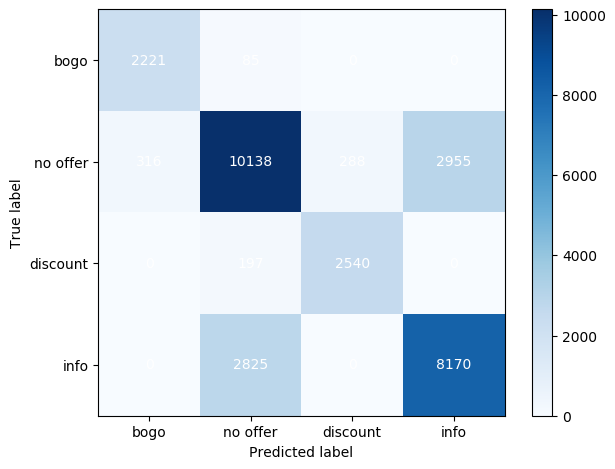

In [34]:
# Compute the confusion matrix
best_cm = confusion_matrix(y_test, best_pred)

# Visualize the confusion matrix as a heatmap
fig, ax = plt.subplots()
im = ax.imshow(best_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(best_cm.shape[1]),
       yticks=np.arange(best_cm.shape[0]),
       xticklabels=['bogo', 'no offer', 'discount', 'info'],
       yticklabels=['bogo', 'no offer', 'discount', 'info'],
       xlabel='Predicted label',
       ylabel='True label')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Loop over data to add annotations
for i in range(best_cm.shape[0]):
    for j in range(best_cm.shape[1]):
        ax.text(j, i, best_cm[i, j], ha="center", va="center", color="white")

fig.tight_layout()
plt.show()

Feature ranking:
1. feature 5 age (0.180973)
2. feature 2 income (0.177840)
3. feature 4 membership_duration (0.152427)
4. feature 3 difficulty (0.133604)
5. feature 1 duration (0.130295)
6. feature 0 reward (0.129032)
7. feature 6 web (0.041689)
8. feature 8 email (0.040847)
9. feature 9 social (0.009654)
10. feature 10 mobile (0.001462)
11. feature 11 gender = _F (0.001429)
12. feature 12 gender = _M (0.000749)
13. feature 7 gender = _O (0.000000)


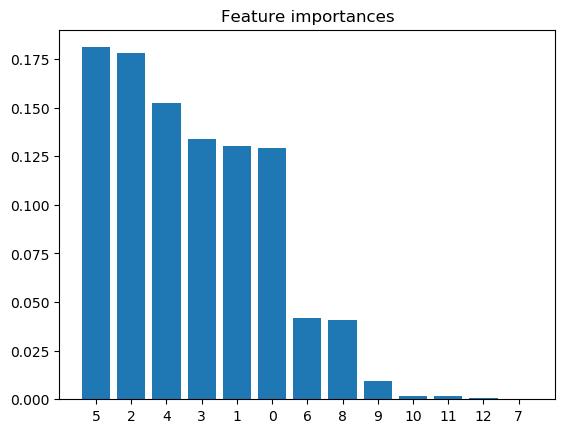

In [35]:
# get feature importances
best_importances = best_rf.feature_importances_

# sort feature importances in descending order
indices = np.argsort(best_importances)[::-1]

# print out the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[f], best_importances[indices[f]]))

# plot the feature importances
plt.title("Feature importances")
plt.bar(range(X.shape[1]), best_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.show()